# Major League Baseball Similarity Scores

*The information used here was obtained free of charge from and is copyrighted by Retrosheet. Interested parties may contact Retrosheet at "www.retrosheet.org".*

Summary
- Alternative to the similarity scores found on Baseball Reference and originally developed by Bill James.
- BBREF method is vaguely similar to the KNN algo
 - - start with perfect scores (0 to 1000 pts) and subtract points for differences
 - - values are fixed  
- BBREF method for batters includes positional adjustment which can skew results
- BBREF method for batters includes xbh/slg/hits/ba/rbi
- BBREF method for pitchers includes wins/losses


## 1. Introduction

Baseball Reference (BR) player pages include a section for similarity scores, a concept was originally described by Bill James in the 1980s and implemented on the player pages of Baseball Reference. The purpose is to identify the players most like the player of interest either by career totals or by age.
To calculate the similarity score using the James/BR method, start with 1000 points and subtract for the observed differences in a series of offensive categories. Additionally, points are subtracted for differences in the primary position. The offensive categories are games played, at bats, runs scored, hits, doubles, triples, home runs, RBI, walks, strikeouts, stolen bases, batting average, and slugging percentage. Point values are constant for each deduction. The exact methodology is described in detail here. Higher point values indicate a greater degree of similarity, with 1000 points as the maximum, i.e., perfectly correlated. Minimum qualifications are 500 career at bats.

For pitchers, the categories are wins, losses, winning percentage, earned run average (ERA), games pitched, starts, complete games, innings pitched, hits allowed, strikeouts, walks, shutouts, and saves. Points are also deducted for left- vs right-handed throwers, as well as starter vs reliever. Minimum qualification is 100 career innings pitched.

BR points out that similarity scores are not indicative of the relative value between players. Player value depends on several factors not in the data set. Wins above replacement (WAR), both offensive and defensive, account for run scoring context in the form of adjustments for park, league, and position adjustments, among others.


## 2. Motivation
This project will implement an alternative methodology for calculating similarity scores than that offered by BR and James. To understand why, we examine the BR procedure and the issues we want to address.

Similarity score using the James/BR method start with 1000 points and deduct for observed differences in thirteen offensive categories as well as primary fielding position. The offensive categories are games played, at bats, runs scored, hits, doubles, triples, home runs, RBI, walks, strikeouts, stolen bases, batting average, and slugging percentage. Point values for each deduction vary by category.

Now suppose that the aggregated statistics in these categories (for each player) represent a feature vector in 14-dimensional space. Deductions in the similarity score, then, can be thought of as a distance between pairwise combinations of feature vectors (players). This procedure is like the K nearest neighbor (KNN) algorithm without the decision-making process, typically a regression or classification task. Instead, we rank the most similar players by score. However, problems arise when correlated and irrelevant features are included, or relevant features are excluded from the calculation.

For pitchers, the categories are wins, losses, winning percentage, earned run average (ERA), games pitched, starts, complete games, innings pitched, hits allowed, strikeouts, walks, shutouts, and saves. Points are also deducted for left- vs right-handed throwers, as well as starter vs reliever. This process is repeated for each pairwise combination of qualified players, subject to a governing criterion (player age less than or equal to 30 years old, for example).




### 2.1 Correlated Features

High correlation has the effect of increasing the influence of the features in question. For position players, BR includes hits, doubles, triples, home runs, batting average, and slugging percentage. The effect of an extra double, for example, will carry across 3 features: doubles, batting average, and slugging percentage. Ideally, we want a feature set with zero correlation, i.e., the features are orthogonal. Here is the correlation matrix of the BR feature set for position players (regular season games, through the 2022 season):

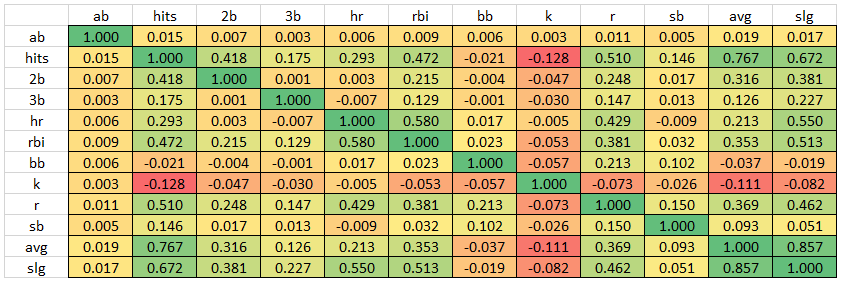


We select a feature set (without resorting to principal components) that has better correlation coefficients:

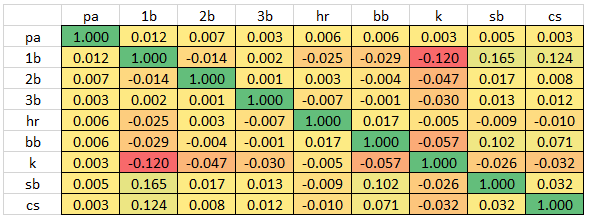

We can, likewise, select a feature set for pitcher scores the reduces the correlation coefficients compared to the BR method. We use games started, complete games, shutouts, outs played (alternate measure of innings pitched), opponent singles, opponent doubles, opponent triples, opponent home runs, hit by pitch, walks, strikeouts, stolen bases, caught stealing, grounded into double plays, earned runs, and saves. This set of features does not eliminate the issue of multicollinearity, but it does reduce it while preserving important information about the role of a pitcher on his team.

### 2.2 Irrelevant Features

We expect similarity scores to compare players based on their individual impact on the field. We should, therefore, avoid statistics that are heavily influenced by their teammates. Runs and RBIs are features in the BR scores for position players that should be excluded because they depend on a player’s teammates either batting them in or getting on base ahead of them.

BR deducts points for differences in the primary positions between players. We eliminate the positional adjustments for two reasons:
-	We are most interested in comparing the offensive performance of players, and
-	Identifying the primary position does not inform us about the quality of the player’s defensive performance.

It is plausible (likely, even) that a player’s profile will correlate to their primary position. Power hitting sluggers are more likely to play corner infield or outfield positions; light hitting, defense-first players are more likely to play up the middle. However, if we wish to include fielding positions as a factor, it should be done as a governing criterion. For pitchers, we exclude the left- and right-handed adjustments as well.

We also exclude any rate statistics as features. For a carefully chosen set of counting statistics, the rate statistics are implied in the results.


### 2.3 Excluded Features
BR includes batting average and slugging percentage as features which indirectly describes a player’s hit distribution. We omit BA and SLG and include the hit distribution explicitly as counting statistics.

For pitchers, the BR method places emphasis on game-level outcomes: wins, losses, saves, winning percentage, complete games, shoutouts, and innings pitched. The distribution of hits allowed by a pitcher are not included either explicitly or implicitly. Outcomes that occur at the event level such as hit-by-pitch, double plays, and caught stealing are also omitted.


### 2.4 Alternative Methodology
Our scoring system is based on the pairwise Euclidean distance between the aggregated statistics for a given criteria. The process is simple. First, we define the criteria over we want; games played less than or equal to 500, for example. Then we aggregate and max-min scale the statistics for the features we have defined. Next, we calculate the pairwise distance between players over the scaled feature space. Finally, we transform the distances into a score with the same range (0 to 1000) as the BR scoring system. For batters,

$$ score = 1000*\left(1 - \frac{d}{2.3085}\right)$$

where $d$ is the distance and the constant $2.3085$ if the largest observed value is the position player matrix. For pitchers,

$$ score = 1000*\left(1-\frac{d}{3.246566 }\right)
$$

Higher scores indicate greater similarity between players.


## 3. ETL

Our data set consists of regular season game logs from Retrosheet for the 1871-2022 seasons. The fields that are cumulative sums are primarily used as criteria for slicing the data frame. The remaining fields are the statistics accumulated for each *game_id* or biographical information related to *player_id*.






### 3.1 Position Players

The data file for positional player contains the following fields:

- *player_id*: Retrosheet's 8-digit alpha-numeric code for the player of record,
- *use_name*: Player’s name commonly used by the media,
- *last_name*: Player’s last name,
- *hof*: Variable indicating if the player has been inducted into the hall of fame (t/f),
- *birth_date*: Birth date of the player of record,
- *player_debut_date*: Debut date of the player of record,
- *player_last_date*: Date of the last appearance for the player of record,
- *bat_hand*: Variable indicating the batting hand of the player of record (l/r/s),
- *throw_hand*: Variable indicating the throwing hand of the player of record (l/r),
- *height*: Height of the player of record in inches,
- *weight*: Weight of the player of record in pounds,
- *age*: Age of the player of record on the date of the game in years at the conclusion of *game_id*,
- *delta_t*: Elapsed time (in years) between the player’s debut and the game of record at the conclusion of *game_id*. This is an analog to service time,
- *game_id*: Retrosheet's 12-digit alpha-numeric code uniquely identifying the game of record,
- *game_date*: Date of the game,
- *season_type*: Variable indicating the season type for the game of record (‘rs’: regular season),
- *games*: Cumulative sum of games played by the player of record at the conclusion of *game_id*,
- *pa*: Cumulative sum of plate appearances by the player of record at the conclusion of *game_id*,
- *ab*: Cumulative sum of by the player of record at the conclusion of *game_id*,
- *1b*: Number of singles hit by the player of record for *game_id*,
- *2b*: Number of doubles hit by the player of record for *game_id*,
- *3b*: Number of triples hit by the player of record for *game_id*,
- *hr*: Number of home runs hit by the player of record for *game_id*,
- *rbi*: Number of runs batted in awarded to the player of record for *game_id*,
- *sach*: Number of sacrifice bunts awarded to the player of record during *game_id*,
- *sacf*: Number of sacrifice flies awarded to the player of record during *game_id*,
- *hbp*: Number of times the player of record was hit by a pitch during *game_id*,
- *bb*: Number of walks awarded to the player of record during *game_id*,
- *ibb*: Number of intentional walks awarded to the player of record during *game_id*,
- *k*: Number of times the player of record has struck out during *game_id*,
-*r*: Number of runs scored by the player of record during *game_id*,
- *sb*: Number of stolen bases by the player of record during *game_id*,
- *cs*: Number of times the player of record was caught stealing during *game_id*,
- *fp_1*: Number of outs played as the pitcher by the player of record during *game_id*,
- *fp_2* Number of outs played as the catcher by the player of record during *game_id*,
- *fp_3*: Number of outs played as the first basemen by the player of record during *game_id*,
- *fp_4*: Number of outs played as the second basemen by the player of record during *game_id*,
- *fp_5*: Number of outs played as the third basemen by the player of record during *game_id*,
- *fp_6*: Number of outs played as the shortstop by the player of record during *game_id*,
- *fp_7*: Number of outs played as the left fielder by the player of record during *game_id*,
- *fp_8*: Number of outs played as the center fielder by the player of record during *game_id*,
- *fp_9*: Number of outs played as the right fielder by the player of record for *game_id*.



### 3.2 Pitchers

The data file for pitchers contains the following fields:
- *player_id*: Retrosheet's 8-digit alpha-numeric code for the player of record,
- *use_name*: Player’s name commonly used by the media,
- *last_name*: Player’s last name,
- *hof*: Variable indicating if the player has been inducted into the hall of fame (t/f),
- *birth_date*: Birth date of the player of record,
- *player_debut_date*: Debut date of the player of record,
- *player_last_date*: Date of the last appearance for the player of record,
- *bat_hand*: Variable indicating the batting hand of the player of record (l/r/s),
- *throw_hand*: Variable indicating the throwing hand of the player of record (l/r),
- *height*: Height of the player of record in inches,
- *weight*: Weight of the player of record in pounds,
- *age*: Age of the player of record on the date of the game in years at the conclusion of *game_id*,
- *delta_t*: Elapsed time (in years) between the player’s debut and the game of record at the conclusion of *game_id*,
- *game_id*: Retrosheet's 12-digit alpha-numeric code uniquely identifying the game of record,
- *game_date*: Date of the game,
- *season_type*: Variable indicating the season type for the game of record (‘rs’: regular season),
- *g*: Cumulative sum of appearances by the player of record at the conclusion of *game_id*,
- *gs*: Cumulative sum of games started by the player of record at the conclusion of *game_id*,
- *outs_played*: Cumulative sum of outs played by the player of record at the conclusion of *game_id*,
- *ip*: Cumulative sum of innings pitched by the player of record at the conclusion of *game_id*, (ip=outs played/3)
- *cg*: Indicator if the player of record pitched a complete game,
- *sho* Indicator if the player of record pitched a shutout,
- *pa*: Cumulative sum of plate appearances faced by the player of record at the conclusion of *game_id*,
- *ab*: Sum of at bats faced by the player of record at the during *game_id*,
- *1b*: Number of singles hit against the player of record during *game_id*,
- *2b*: Number of doubles hit against the player of record during *game_id*,
- *3b*: Number of triples hit against the player of record during *game_id*,
- *hr*: Number of home runs hit against the player of record during *game_id*,
- *sach*: Number of sacrifice hits against the player of record during *game_id*,
- *sacf*: Number of sacrifice flies hit against the player of record during *game_id*,
- *hbp*: Number of times the player of record hit a batter with a pitch during *game_id*,
- *bb*:  Number of walks charged to the player of record during *game_id*,
- *ibb*:  Number of intentional walks charged to the player of record during *game_id*,
- *k*:  Number of strikeouts for the player of record during *game_id*,
- *sb*:  Number of stolen bases against the player of record during *game_id*,
- *cs*:  Number of runners caught stealing against the player of record during *game_id*,
- *pickoff*:  Number of runners picked off the player of record during *game_id*,
- *gidp*:  Number of grounded into double plays awarded to the player of record during *game_id*,  
- *gitp*:  Number of grounded into triple plays awarded to the player of record during *game_id*,  
- *r*:  Number of runs charged to the player of record during *game_id*,
- *er*:  Number of earned runs charged to the player of record during *game_id*,
- *balk*:  Number of balks charged to the player of record during *game_id*,
- *win*: Indicator if the player of record recorded a win for *game_id*,
- *loss*: Indicator if the player of record recorded a loss for *game_id*,
- *save*: Indicator if the player of record recorded a save for *game_id*,

## 4. Similarity Scores

### 4.1 Retrieve Data Files

In [1]:
!wget -P /content/ https://github.com/cmtoner/mlb_similarity_scores/raw/7ee7cc90c8714a1e3bdc2d494052ee17c81dcabc/rs_sim_score_batters_part00.zip
!wget -P /content/ https://github.com/cmtoner/mlb_similarity_scores/raw/7ee7cc90c8714a1e3bdc2d494052ee17c81dcabc/rs_sim_score_batters_part01.zip
!wget -P /content/ https://github.com/cmtoner/mlb_similarity_scores/raw/7ee7cc90c8714a1e3bdc2d494052ee17c81dcabc/rs_sim_score_batters_part02.zip
!wget -P /content/ https://github.com/cmtoner/mlb_similarity_scores/raw/7ee7cc90c8714a1e3bdc2d494052ee17c81dcabc/rs_sim_score_batters_part03.zip
!wget -P /content/ https://github.com/cmtoner/mlb_similarity_scores/raw/7ee7cc90c8714a1e3bdc2d494052ee17c81dcabc/rs_sim_score_batters_part04.zip
!wget -P /content/ https://github.com/cmtoner/mlb_similarity_scores/raw/7ee7cc90c8714a1e3bdc2d494052ee17c81dcabc/rs_sim_score_batters_part05.zip
!wget -P /content/ https://github.com/cmtoner/mlb_similarity_scores/raw/7ee7cc90c8714a1e3bdc2d494052ee17c81dcabc/rs_sim_score_batters_part06.zip
!wget -P /content/ https://github.com/cmtoner/mlb_similarity_scores/raw/7ee7cc90c8714a1e3bdc2d494052ee17c81dcabc/rs_sim_score_pitchers_part00.zip
!wget -P /content/ https://github.com/cmtoner/mlb_similarity_scores/raw/7ee7cc90c8714a1e3bdc2d494052ee17c81dcabc/rs_sim_score_pitchers_part01.zip

--2024-05-12 02:13:51--  https://github.com/cmtoner/mlb_similarity_scores/raw/7ee7cc90c8714a1e3bdc2d494052ee17c81dcabc/rs_sim_score_batters_part00.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cmtoner/mlb_similarity_scores/7ee7cc90c8714a1e3bdc2d494052ee17c81dcabc/rs_sim_score_batters_part00.zip [following]
--2024-05-12 02:13:51--  https://raw.githubusercontent.com/cmtoner/mlb_similarity_scores/7ee7cc90c8714a1e3bdc2d494052ee17c81dcabc/rs_sim_score_batters_part00.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18978939 (18M) [application/zip]
Saving to: ‘/content/rs_sim_score_batters_par

Import Packages

In [2]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

from sqlalchemy import create_engine, text
from sklearn.metrics import pairwise_distances

### 4.2 Position Players



#### 4.2.1 Create Data Frame

Concatenate the position player files to create a data frame.

In [3]:
def create_batter_df():
  file_names = ["/content/rs_sim_score_batters_part00.zip",
                "/content/rs_sim_score_batters_part01.zip",
                "/content/rs_sim_score_batters_part02.zip",
                "/content/rs_sim_score_batters_part03.zip",
                "/content/rs_sim_score_batters_part04.zip",
                "/content/rs_sim_score_batters_part05.zip",
                "/content/rs_sim_score_batters_part06.zip"]

  df_list = []

  for fn in file_names:
    df_list.append(pd.read_csv(fn,
                              header=0,
                              index_col=False))
  return(pd.concat(df_list))

df0 = create_batter_df()

#### 4.2.2 Calculate Position Player Similarity Scores

Define three convenience functions. The first aggregates the batter counting statistics for a given criterion. The second calculates the batter similarity scores based on the pairwise distances in the feature space. The third generates a report to evaluate the results.

In [4]:
def aggregate_batter_stats(df):

    # define counting stat colummns
    stat_cols = ['1b','2b','3b','hr','rbi','sach','sacf','hbp','bb',
                'ibb','k','r','sb','cs','fp_1','fp_2','fp_3','fp_4','fp_5','fp_6',
                'fp_7','fp_8','fp_9']

    # group the df by player id and counting stats
    df_g = df[['player_id']+[stat_cols[0]]].groupby('player_id')[stat_cols[0]].sum()
    df_g = pd.DataFrame(df_g)

    for col in stat_cols[1:]:
        df_g[col] = df[['player_id']+[col]].groupby('player_id')[col].sum()

    # add cumulative stats (games, ab, pa) to df_g
    df_g['games'] = df[['player_id','games']].groupby('player_id')['games'].max()
    df_g['ab'] = df[['player_id','ab']].groupby('player_id')['ab'].max()
    df_g['pa'] = df[['player_id','pa']].groupby('player_id')['pa'].max()

    # add rate stats to df_g
    # for comparison/reporting purposes only - not used to calcuate scores
    df_g['obp'] = (df_g['1b']+df_g['2b']+df_g['3b']+df_g['hr']+df_g['bb']+df_g['ibb']+df_g['hbp']) / (df_g['ab']+df_g['bb']+df_g['ibb']+df_g['hbp']+df_g['sacf'])
    df_g['slg'] = (df_g['1b'] + 2*df_g['2b'] + 3*df_g['3b'] + 4*df_g['hr'])/df_g['ab']
    df_g['ops'] = df_g['obp'] + df_g['slg']
    df_g['ba'] = (df_g['1b']+df_g['2b']+df_g['3b']+df_g['hr'])/df_g['ab']
    df_g['iso'] = df_g['slg']-df_g['ba']

    return(df_g)

def calc_batter_scores(df_g, stat_cols=['pa','1b','2b','3b','hr','bb','k','sb','cs']):
    # max-min scale the counting stats in df_g
    df_g_sc = df_g.copy()

    for c in stat_cols:
        df_g_sc[c] = (df_g_sc[c] - df_g_sc[c].min()) / (df_g_sc[c].max() - df_g_sc[c].min())

    # replace Nan with 0
    df_g_sc = df_g_sc.fillna(0)
    # keep stat cols only
    df_g_sc = df_g_sc[stat_cols]

    df_dist = pd.DataFrame(pairwise_distances(df_g_sc, metric='l2'),
                           columns=df_g_sc.index)
    df_dist.index = df_g_sc.index

    # scale to 0-1000
    mx = 2.3085   # largest observed distance over all career stats
    mn = 0.0      # smalles possible value
    df_dist = 1000*(1-(df_dist-mn) / (mx-mn))

    #catch and rounding errors on the diagonal
    np.fill_diagonal(df_dist.values, 1000)

    return(df_dist)

def gen_batter_report(player_id, df, grp_stats, sim_scores, n=10):
    # get top n scores
    report = grp_stats.loc[sim_scores[player_id].sort_values(ascending=False)[:n].index]
    report = report.merge(sim_scores[player_id].sort_values(ascending=False)[:n],
                          how='left',
                          left_index=True,
                          right_index=True)
    report = report.rename(columns={player_id:'sim_score'})
    report = report.reset_index()

    report = report.merge(df[['player_id','use_name','last_name','bat_hand','throw_hand','height','weight','hof']].drop_duplicates(),
                      how='inner',
                      left_on=['player_id'],
                      right_on=['player_id'])

    # order columns
    report = report[['player_id','use_name','last_name','bat_hand','throw_hand',
                     'height','weight','hof','sim_score','games','ab','pa','1b','2b','3b',
                     'hr','rbi','sach','sacf','hbp','bb','ibb','k','r','sb','cs','obp','slg','ops',
                     'ba','iso','fp_1','fp_2','fp_3','fp_4','fp_5','fp_6','fp_7','fp_8','fp_9']]

    return(report)



Apply model to player data. Here, we calculate scores for career statistics by setting $games<=1000000$.

In [5]:
#aggregate df0
print('Aggregating data...')
# define criterion
m0 = df0['games'] <= 10**6
# apply criterion
df_agg = aggregate_batter_stats(df0.loc[m0])
print('\tDone')

#calc scores
#hitting cols only
print('Calculating similarity scores...')
cols = ['pa','1b','2b','3b','hr','bb','k','sb','cs']
df_scores = calc_batter_scores(df_agg,
                               stat_cols=cols)
print('\tDone')


Aggregating data...
	Done
Calculating similarity scores...
	Done


Generate a report for Jim Rice (note: this data is current up to the 2022 season and does not include data from 2023 or 2024). Here, we do not include fielding positions as features.

In [6]:
#generate report for Jim Rice
pid = 'ricej001'
print(f'Generating report for {pid}')
n_keep = 6
df_report = gen_batter_report(player_id=pid,
                              n=n_keep,
                              df=df0,
                              grp_stats=df_agg,
                              sim_scores=df_scores)
print('\tDone')

df_report.round(3).transpose()

Generating report for ricej001
	Done


,0,1,2,3,4,5
player_id,ricej001,sierr001,snidd101,fiskc001,santr102,banke101
use_name,Jim,Ruben,Duke,Carlton,Ron,Ernie
last_name,Rice,Sierra,Snider,Fisk,Santo,Banks
bat_hand,r,b,l,r,r,r
throw_hand,r,r,r,r,r,r
height,74.0,73.0,72.0,75.0,72.0,73.0
weight,200.0,175.0,179.0,200.0,190.0,180.0
hof,t,f,t,t,t,t
sim_score,1000.0,906.992,905.316,904.685,903.301,902.026
games,2087,2177,2117,2474,2241,2519


BR top 5 similarity scores for Jim Rice.



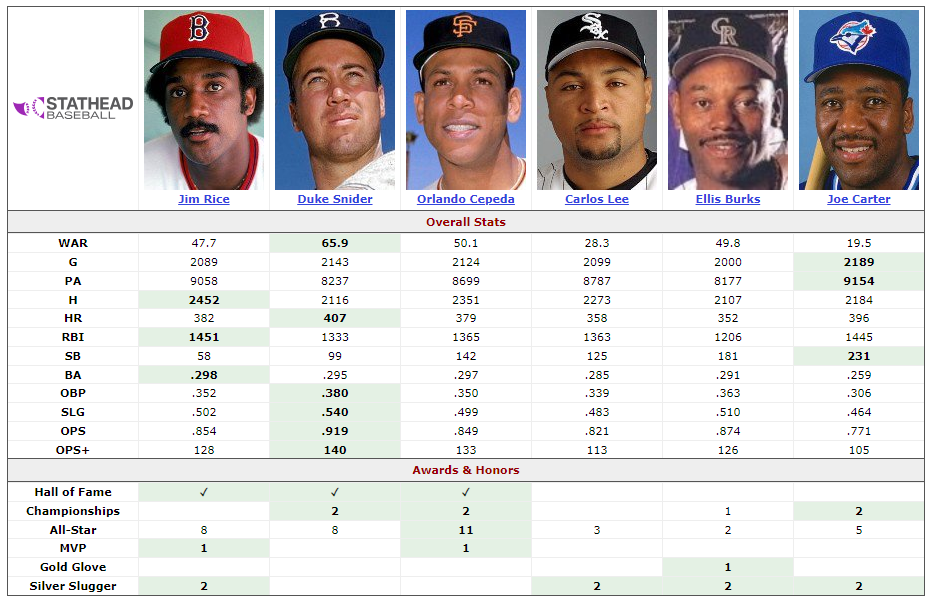

Generate report with positional adjustment.

In [7]:
#hitting cols with positional adjustment
print('Calculating similarity scores with positional adjustment...')
cols = ['pa','1b','2b','3b','hr','bb','ibb','k','sb','cs','fp_1', 'fp_2',
        'fp_3', 'fp_4', 'fp_5', 'fp_6', 'fp_7', 'fp_8', 'fp_9']
df_scores = calc_batter_scores(df_agg,
                               stat_cols=cols)
print('\tDone')

#generate report for Jim Rice WITH positional adjustment
pid = 'ricej001'
print(f'Generating report for {pid}')
n_keep = 6
df_report = gen_batter_report(player_id=pid,
                              n=n_keep,
                              df=df0,
                              grp_stats=df_agg,
                              sim_scores=df_scores)
print('\tDone')

df_report.round(3).transpose()

Calculating similarity scores with positional adjustment...
	Done
Generating report for ricej001
	Done


,0,1,2,3,4,5
player_id,ricej001,ibanr001,fostg001,braur002,hortw101,hollm001
use_name,Jim,Raul,George,Ryan,Willie,Matt
last_name,Rice,Ibanez,Foster,Braun,Horton,Holliday
bat_hand,r,l,r,r,r,r
throw_hand,r,r,r,r,r,r
height,74.0,74.0,73.5,74.0,71.0,76.0
weight,200.0,200.0,180.0,200.0,209.0,230.0
hof,t,f,f,f,f,f
sim_score,1000.0,896.01,886.281,858.785,857.305,855.462
games,2087,2122,1948,1765,2023,1901


In [8]:
# clean house
del cols, df0, df_agg, df_scores, df_report, pid, n_keep, m0

### 4.3 Pitchers

#### 4.3.1 Create Data Frame

Concatenate pitcher files to create data frame.

In [9]:
def create_pitcher_df():
  df = pd.concat([pd.read_csv('/content/rs_sim_score_pitchers_part00.zip',
                              header=0,
                              index_col=False),
                  pd.read_csv('/content/rs_sim_score_pitchers_part01.zip',
                              header=0,
                              index_col=False)
                  ])
  return(df)

df1 = create_pitcher_df()

#### 4.3.2 Calculate Pitcher Similiarity Scores

Define three convenience functions. The first aggregates the pitcher counting statistics for a given criterion. The second calculates the pitcher similarity scores based on the pairwise distances in the feature space. The third generates a report to evaluate the results.


In [10]:
def aggregate_pitcher_stats(df):

    stat_cols = ['cg', 'sho', 'ab', '1b', '2b', '3b','hr', 'sach', 'sacf',
                 'hbp', 'bb', 'ibb', 'k', 'sb', 'cs', 'pickoff','gidp', 'gitp',
                 'r', 'er', 'balk', 'win', 'loss', 'save']

    # group the query by player id
    print('Grouping pitcher data...')
    df_g = df[['player_id']+[stat_cols[0]]].groupby('player_id')[stat_cols[0]].sum()
    df_g = pd.DataFrame(df_g)

    for c in stat_cols[1:]:
        df_g[c] = df[['player_id']+[c]].groupby('player_id')[c].sum()
    print('\tDone')

    # add cumulative stats (games, games started, outs_played, innings pitched, and plate appearances)
    # back into df_g
    df_g['g'] = df[['player_id','g']].groupby('player_id')['g'].max()
    df_g['gs'] = df[['player_id','gs']].groupby('player_id')['gs'].max()
    df_g['outs_played'] = df[['player_id','outs_played']].groupby('player_id')['outs_played'].max()
    df_g['ip'] = df[['player_id','ip']].groupby('player_id')['ip'].max()
    df_g['pa'] = df[['player_id','pa']].groupby('player_id')['pa'].max()

    # add rate stats to df_g
    # for comparison purposes only
    print('Adding rate stats...')
    df_g['era'] = df_g['er']*27/df_g['outs_played']
    df_g['whip'] = 3*(df_g['bb']+df_g['ip']) / df_g['outs_played']
    df_g['h9'] = 27*(df_g['1b']+df_g['2b']+df_g['3b']+df_g['hr']) / df_g['outs_played']
    df_g['hr9'] = 27*df_g['hr'] / df_g['outs_played']
    df_g['bb9'] = 27*df_g['bb'] / df_g['outs_played']
    df_g['so9'] = 27*df_g['k'] / df_g['outs_played']
    df_g['opp_avg'] = (df_g['1b']+df_g['2b']+df_g['3b']+df_g['hr'])/df_g['ab']
    df_g['opp_obp'] = (df_g['1b']+df_g['2b']+df_g['3b']+df_g['hr']+df_g['bb']+df_g['hbp']) / (df_g['ab']+df_g['bb']+df_g['hbp']+df_g['sacf'])
    df_g['opp_slg'] = (df_g['1b']+2*df_g['2b']+3*df_g['3b']+4*df_g['hr'])/df_g['ab']
    df_g['opp_ops'] = df_g['opp_obp'] + df_g['opp_slg']
    df_g['opp_iso'] = df_g['opp_slg'] - df_g['opp_avg']
    print('\tDone')

    return(df_g)

def calc_pitcher_scores(df_g,
                        stat_cols=['g','gs','cg','sho','pa','ip','1b','2b','3b','hr','hbp','bb','k','sb','cs','pickoff','gidp','er','save']):

    # max-min scale the remaining counting stats in df_g
    df_g_sc = df_g.copy()

    for c in stat_cols:
        df_g_sc[c] = (df_g_sc[c] - df_g_sc[c].min()) / (df_g_sc[c].max() - df_g_sc[c].min())

    # replace Nan with 0
    df_g_sc = df_g_sc.fillna(0)
    # keep stat cols only
    df_g_sc = df_g_sc[stat_cols]

    df_dist = pd.DataFrame(pairwise_distances(df_g_sc, metric='l2'),
                           columns=df_g_sc.index)
    df_dist.index = df_g_sc.index

    # scale to 1000
    mx = 3.246566   # largest observed value
    mn = 0.0        # smallest possible value
    df_dist = 1000*(1-(df_dist-mn) / (mx-mn))

    #catch and rounding errors on the diagonal
    np.fill_diagonal(df_dist.values, 1000)

    return(df_dist)


def gen_pitcher_report(player_id, df, grp_stats, sim_scores, n=10):

    report = grp_stats.loc[sim_scores[player_id].sort_values(ascending=False)[:n].index]
    report = report.merge(sim_scores[player_id].sort_values(ascending=False)[:n],
                      how='left',
                      left_index=True,
                      right_index=True)
    report = report.rename(columns={player_id:'sim_score'})
    report = report.reset_index()

    report = report.merge(df[['player_id','use_name','last_name','bat_hand','throw_hand','height','weight','hof']].drop_duplicates(),
                      how='inner',
                      left_on=['player_id'],
                      right_on=['player_id'])

    # order columns
    report = report[['player_id','use_name','last_name','bat_hand','throw_hand',
                     'height','weight','hof','sim_score','g','gs','cg','sho','win',
                     'loss','save','ab','pa','ip','1b','2b','3b','hr','hbp','bb',
                     'k','sb','cs','pickoff','gidp','er','balk','era','whip',
                     'h9','hr9','bb9','so9','opp_avg','opp_obp','opp_slg','opp_ops',
                     'opp_iso']]

    return(report)


Apply model to pitcher data. Here, we are looking at a pitchers career stats by setting $g <= 1000000$.

In [11]:
#aggregate df1
m0 = df1['g']<=10**6
print('Aggregating pitcher data...')
df_agg = aggregate_pitcher_stats(df1.loc[m0])

#calc scores
cols = ['gs','cg','sho','outs_played','1b','2b','3b','hr','hbp','bb','k','sb','cs','gidp','er','save']
print('Calculating similarity scores...')
df_scores = calc_pitcher_scores(df_agg,
                               stat_cols=cols)
print('\tDone')

Aggregating pitcher data...
Grouping pitcher data...
	Done
Adding rate stats...
	Done
Calculating similarity scores...
	Done


Generate report for Pedro Martinez

In [12]:
# generate report for Pedro Martinez
pid = 'martp001'
n_keep = 6
df_report = gen_pitcher_report(player_id=pid,
                               n=n_keep,
                               df=df1,
                               grp_stats=df_agg,
                               sim_scores=df_scores)

df_report.round(3).transpose()

,0,1,2,3,4,5
player_id,martp001,schem001,hernf002,hamec001,verlj001,burna001
use_name,Pedro,Max,Felix,Cole,Justin,A.J.
last_name,Martinez,Scherzer,Hernandez,Hamels,Verlander,Burnett
bat_hand,r,r,r,l,r,r
throw_hand,r,r,r,l,r,r
height,71.0,75.0,75.0,75.0,77.0,77.0
weight,170.0,215.0,225.0,175.0,200.0,204.0
hof,t,f,f,f,f,f
sim_score,1000.0,914.599,901.103,896.678,894.949,889.072
g,476,430,419,423,482,435


BR top 5 similarity scores for Pedro Martinez.

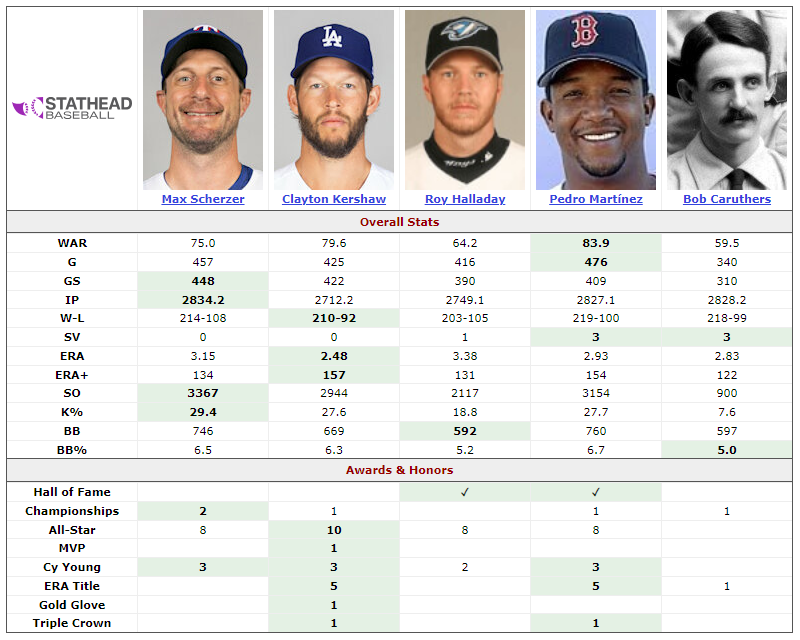

In [13]:
# clean house
del cols, df1, df_agg, df_report, df_scores, m0, n_keep, pid

## 5. Using Different Criteria

In Section 4.2 and 4.3, we used games as our criterion and compared players career stats by setting games to a absurdly large number. However, games played may not be the best choice, particularly for players who are still active.

#### 5.1 Position Players

For position players, we can use age, *delta_t* (analog for service time), plate appearances, and at-bats. Begin by re-loading the position player data frame, then generate a series of reports for Ken Griffey Jr. using different criteria.

In [14]:
df0 = create_batter_df()

##### 5.1.1 Age

Here, we look at players age 30 or younger by setting $age<=31$.

In [15]:
#aggregate df0
print('Aggregating data...')
# define criterion
m0 = df0['age'] <= 31.0
# apply criterion
df_agg = aggregate_batter_stats(df0.loc[m0])
print('\tDone')

#calc scores
#hitting cols only
print('Calculating similarity scores...')
cols = ['pa','1b','2b','3b','hr','bb','k','sb','cs']
df_scores = calc_batter_scores(df_agg,
                               stat_cols=cols)
print('\tDone')



Aggregating data...
	Done
Calculating similarity scores...
	Done


In [16]:
#generate report for Ken Griffey Jr
pid = 'grifk002'
print(f'Generating report for {pid}')
n_keep = 6
df_report = gen_batter_report(player_id=pid,
                              n=n_keep,
                              df=df0,
                              grp_stats=df_agg,
                              sim_scores=df_scores)
print('\tDone')

df_report.round(3).transpose()

Generating report for grifk002
	Done


,0,1,2,3,4,5
player_id,grifk002,rodra001,jonea002,robif103,bencj101,cabrm001
use_name,Ken,Alex,Andruw,Frank,Johnny,Miguel
last_name,Griffey,Rodriguez,Jones,Robinson,Bench,Cabrera
bat_hand,l,r,r,r,r,r
throw_hand,l,r,r,r,r,r
height,75.0,75.0,73.0,73.0,73.0,74.0
weight,195.0,190.0,170.0,183.0,197.0,180.0
hof,t,f,f,t,t,f
sim_score,1000.0,911.13,886.588,886.578,833.056,824.443
games,1677,1683,1767,1628,1629,1670


##### 5.1.2 Plate Appearances

Set *plate appearances* <= 7000, and repeat:

In [17]:
#aggregate df0
print('Aggregating data...')
# define criterion
m0 = df0['pa'] <= 7000
# apply criterion
df_agg = aggregate_batter_stats(df0.loc[m0])
print('\tDone')

#calc scores
#hitting cols only
print('Calculating similarity scores...')
cols = ['pa','1b','2b','3b','hr','bb','k','sb','cs']
df_scores = calc_batter_scores(df_agg,
                               stat_cols=cols)
print('\tDone')

#generate report for Ken Griffey Jr
pid = 'grifk002'
print(f'Generating report for {pid}')
n_keep = 6
df_report = gen_batter_report(player_id=pid,
                              n=n_keep,
                              df=df0,
                              grp_stats=df_agg,
                              sim_scores=df_scores)
print('\tDone')

df_report.round(3).transpose()

Aggregating data...
	Done
Calculating similarity scores...
	Done
Generating report for grifk002
	Done


,0,1,2,3,4,5
player_id,grifk002,rodra001,robif103,jonea002,bellj002,murpd001
use_name,Ken,Alex,Frank,Andruw,Albert,Dale
last_name,Griffey,Rodriguez,Robinson,Jones,Belle,Murphy
bat_hand,l,r,r,r,r,r
throw_hand,l,r,r,r,r,r
height,75.0,75.0,73.0,73.0,73.0,76.0
weight,195.0,190.0,183.0,170.0,190.0,210.0
hof,t,f,t,f,f,f
sim_score,1000.0,942.993,913.931,909.682,906.241,888.718
games,1602,1563,1633,1683,1538,1657


##### 5.1.3 At-Bats

Set *ab* <=7000, and repeat:

In [18]:
#aggregate df0
print('Aggregating data...')
# define criterion
m0 = df0['ab'] <= 7000
# apply criterion
df_agg = aggregate_batter_stats(df0.loc[m0])
print('\tDone')

#calc scores
#hitting cols only
print('Calculating similarity scores...')
cols = ['pa','1b','2b','3b','hr','bb','k','sb','cs']
df_scores = calc_batter_scores(df_agg,
                               stat_cols=cols)
print('\tDone')

#generate report for Ken Griffey Jr
pid = 'grifk002'
print(f'Generating report for {pid}')
n_keep = 6
df_report = gen_batter_report(player_id=pid,
                              n=n_keep,
                              df=df0,
                              grp_stats=df_agg,
                              sim_scores=df_scores)
print('\tDone')

df_report.round(3).transpose()

Aggregating data...
	Done
Calculating similarity scores...
	Done
Generating report for grifk002
	Done


,0,1,2,3,4,5
player_id,grifk002,rodra001,robif103,jonea002,bencj101,murpd001
use_name,Ken,Alex,Frank,Andruw,Johnny,Dale
last_name,Griffey,Rodriguez,Robinson,Jones,Bench,Murphy
bat_hand,l,r,r,r,r,r
throw_hand,l,r,r,r,r,r
height,75.0,75.0,73.0,73.0,73.0,76.0
weight,195.0,190.0,183.0,170.0,197.0,210.0
hof,t,f,t,f,t,f
sim_score,1000.0,938.84,913.575,906.617,892.644,886.583
games,1885,1802,1911,1927,1937,1892


##### 5.1.4 Service Time ($\Delta T$)

MLB service time has a specific definintion and it is not easy extract service time from Retrosheet data, so we use *delta_t* as an analog. Recall *delta_t* is the elapsed time (in years) between the player’s debut and the game of record at the conclusion of *game_id*.

For 10 years, we set *delta_t* <= 11.0 and repeat.

In [19]:
#aggregate df0
print('Aggregating data...')
# define criterion
m0 = df0['delta_t'] <= 11.0
# apply criterion
df_agg = aggregate_batter_stats(df0.loc[m0])
print('\tDone')

#calc scores
#hitting cols only
print('Calculating similarity scores...')
cols = ['pa','1b','2b','3b','hr','bb','k','sb','cs']
df_scores = calc_batter_scores(df_agg,
                               stat_cols=cols)
print('\tDone')

#generate report for Ken Griffey Jr
pid = 'grifk002'
print(f'Generating report for {pid}')
n_keep = 6
df_report = gen_batter_report(player_id=pid,
                              n=n_keep,
                              df=df0,
                              grp_stats=df_agg,
                              sim_scores=df_scores)
print('\tDone')

df_report.round(3).transpose()

Aggregating data...
	Done
Calculating similarity scores...
	Done
Generating report for grifk002
	Done


,0,1,2,3,4,5
player_id,grifk002,rodra001,bellj002,robif103,jonea002,braur002
use_name,Ken,Alex,Albert,Frank,Andruw,Ryan
last_name,Griffey,Rodriguez,Belle,Robinson,Jones,Braun
bat_hand,l,r,r,r,r,r
throw_hand,l,r,r,r,r,r
height,75.0,75.0,73.0,73.0,73.0,74.0
weight,195.0,190.0,190.0,183.0,170.0,200.0
hof,t,f,f,t,f,f
sim_score,1000.0,939.223,916.864,914.875,898.763,879.778
games,1532,1507,1485,1660,1710,1495


In [20]:
# clean house
del cols, df0, df_agg, df_report, df_scores, m0, n_keep, pid

### 5.2 Pitchers

For pitchers, we can use *delta_t*, games (appearances), game starts, innnings pitched, outs player (=ip/3), age, or plate appearances. Begin by re-loading the pitcher data frame, then generate a series of reports for Billy Wagner using different criteria.

In [21]:
df1 = create_pitcher_df()

#### 5.2.1 Age

Set *age*<36.0 and generate a report for Billy Wagner:

In [22]:
#aggregate df1
m0 = df1['g']<=10**6
print('Aggregating pitcher data...')
df_agg = aggregate_pitcher_stats(df1.loc[m0])

#calc scores
cols = ['gs','cg','sho','outs_played','1b','2b','3b','hr','hbp','bb','k','sb','cs','gidp','er','save']
print('Calculating similarity scores...')
df_scores = calc_pitcher_scores(df_agg,
                               stat_cols=cols)
print('\tDone')

#generate report for Billy Wagner
pid = 'wagnb001'
n_keep = 6
df_report = gen_pitcher_report(player_id=pid,
                               n=n_keep,
                               df=df1,
                               grp_stats=df_agg,
                               sim_scores=df_scores)

df_report.round(3).transpose()

Aggregating pitcher data...
Grouping pitcher data...
	Done
Adding rate stats...
	Done
Calculating similarity scores...
	Done


,0,1,2,3,4,5
player_id,wagnb001,kimbc001,jansk001,nathj001,papej001,rodrf003
use_name,Billy,Craig,Kenley,Joe,Jonathan,Francisco
last_name,Wagner,Kimbrel,Jansen,Nathan,Papelbon,Rodriguez
bat_hand,l,r,b,r,r,r
throw_hand,l,r,r,r,r,r
height,70.0,71.0,78.0,76.0,76.0,72.0
weight,180.0,205.0,220.0,195.0,230.0,165.0
hof,f,f,f,f,f,f
sim_score,1000.0,965.8,963.906,960.405,956.614,955.468
g,853,709,766,787,689,948


#### 5.2.2 Service Time ($\Delta T$)

For 10 years, set *delta_t*<=11.0 and repeat:

In [23]:
#aggregate df1
m0 = df1['delta_t']<=11.0
print('Aggregating pitcher data...')
df_agg = aggregate_pitcher_stats(df1.loc[m0])

#calc scores
cols = ['gs','cg','sho','outs_played','1b','2b','3b','hr','hbp','bb','k','sb','cs','gidp','er','save']
print('Calculating similarity scores...')
df_scores = calc_pitcher_scores(df_agg,
                               stat_cols=cols)
print('\tDone')

#generate report for Billy Wagner
pid = 'wagnb001'
n_keep = 6
df_report = gen_pitcher_report(player_id=pid,
                               n=n_keep,
                               df=df1,
                               grp_stats=df_agg,
                               sim_scores=df_scores)

df_report.round(3).transpose()

Aggregating pitcher data...
Grouping pitcher data...
	Done
Adding rate stats...
	Done
Calculating similarity scores...
	Done


,0,1,2,3,4,5
player_id,wagnb001,kimbc001,valvj001,chapa001,jansk001,perct001
use_name,Billy,Craig,Jose,Aroldis,Kenley,Troy
last_name,Wagner,Kimbrel,Valverde,Chapman,Jansen,Percival
bat_hand,l,r,r,l,b,r
throw_hand,l,r,r,l,r,r
height,70.0,71.0,76.0,76.0,78.0,75.0
weight,180.0,205.0,220.0,185.0,220.0,200.0
hof,f,f,f,f,f,f
sim_score,1000.0,953.643,953.466,952.131,952.086,945.577
g,648,596,626,610,671,605


#### 5.2.3 Plate Appearances

Set *pa*<= 2500 and repeat:

In [24]:
#aggregate df1
m0 = df1['pa']<=2500
print('Aggregating pitcher data...')
df_agg = aggregate_pitcher_stats(df1.loc[m0])

#calc scores
cols = ['gs','cg','sho','outs_played','1b','2b','3b','hr','hbp','bb','k','sb','cs','gidp','er','save']
print('Calculating similarity scores...')
df_scores = calc_pitcher_scores(df_agg,
                               stat_cols=cols)
print('\tDone')

#generate report for Billy Wagner
pid = 'wagnb001'
n_keep = 6
df_report = gen_pitcher_report(player_id=pid,
                               n=n_keep,
                               df=df1,
                               grp_stats=df_agg,
                               sim_scores=df_scores)

df_report.round(3).transpose()

Aggregating pitcher data...
Grouping pitcher data...
	Done
Adding rate stats...
	Done
Calculating similarity scores...
	Done


,0,1,2,3,4,5
player_id,wagnb001,valvj001,rodrf003,papej001,jansk001,kimbc001
use_name,Billy,Jose,Francisco,Jonathan,Kenley,Craig
last_name,Wagner,Valverde,Rodriguez,Papelbon,Jansen,Kimbrel
bat_hand,l,r,r,r,b,r
throw_hand,l,r,r,r,r,r
height,70.0,76.0,72.0,76.0,78.0,71.0
weight,180.0,220.0,165.0,230.0,220.0,205.0
hof,f,f,f,f,f,f
sim_score,1000.0,914.234,896.042,884.48,879.516,878.077
g,582,593,560,587,631,649


#### 5.2.4 Innings Pitched

Set *ip <= 700* and repeat:

In [25]:
#aggregate df1
m0 = df1['ip']<=700
print('Aggregating pitcher data...')
df_agg = aggregate_pitcher_stats(df1.loc[m0])

#calc scores
cols = ['gs','cg','sho','outs_played','1b','2b','3b','hr','hbp','bb','k','sb','cs','gidp','er','save']
print('Calculating similarity scores...')
df_scores = calc_pitcher_scores(df_agg,
                               stat_cols=cols)
print('\tDone')

#generate report for Billy Wagner
pid = 'wagnb001'
n_keep = 6
df_report = gen_pitcher_report(player_id=pid,
                               n=n_keep,
                               df=df1,
                               grp_stats=df_agg,
                               sim_scores=df_scores)

df_report.round(3).transpose()

Aggregating pitcher data...
Grouping pitcher data...
	Done
Adding rate stats...
	Done
Calculating similarity scores...
	Done


,0,1,2,3,4,5
player_id,wagnb001,kimbc001,valvj001,papej001,chapa001,jansk001
use_name,Billy,Craig,Jose,Jonathan,Aroldis,Kenley
last_name,Wagner,Kimbrel,Valverde,Papelbon,Chapman,Jansen
bat_hand,l,r,r,r,l,b
throw_hand,l,r,r,r,l,r
height,70.0,71.0,76.0,76.0,76.0,78.0
weight,180.0,205.0,220.0,230.0,185.0,220.0
hof,f,f,f,f,f,f
sim_score,1000.0,902.978,897.688,890.491,888.519,883.979
g,651,709,626,662,667,696


In [27]:
# clean house
del cols, df1, df_agg, df_report, df_scores, m0, n_keep, pid

## 6. Conclusions

In this project, we examined the BR similarity scores and developed an alternative methodology for producing them. As noted, the BR procedure effectively calculates the pairwise distance between feature vectors and transforms these distances to a score with a 1000 point maximum value. We identified and corrected several issues with the BR scores: the inclusion of correlated features, the inclusion of irrelevant features, and the exclusion of relevant features. We formalized the scoring process by explicitly calculating the Euclidean distance between pairwise combinations of feature vectors and transforming the distances into a scoring system like that produced by BR.

Further refinements of the methodology may come in two areas. First, the data used in this project comes from the Retrosheet game logs for all seasons ending in 2022. Modern data collection techniques that track hit type, hit location, exit velocity, launch angle, pitch type, pitch location, etc. would yield more informative results. Likewise, more informative fielding metrics would allow for similarity scores based only on defense, thus removing the need for a fielding position adjustment. Finally, we could apply principal component analysis for both dimension reduction and to create an orthogonal feature set.
